# Project assignment B

For the second part of the final project in **Social Data and visualizations** we investigate fire and rescue incidents in London from 2009 to today based on various attributes from numouros datasets.

## Imports

In [637]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import pickle
import folium
from PyBNG import PyBNG
import missingno as msno
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
sns.set()

In [5]:
#pd.to_pickle(lfb_data, "./firedata.pkl")
firedata = pd.read_pickle("./firedata.pkl")

In [ ]:
#Add the handling time of each incident to the firedata dataframe
handling = firedata['TimeLeft'] - firedata['TimeArrived']
handling_time = []

for x, i in enumerate(handling):
    handling_time.append(handling[x].total_seconds())

firedata['HandlingTimeSeconds'] = handling_time

In [1010]:
#Read in social demographics data
filename = 'london-borough-profiles.csv'

df = pd.read_csv(filename, encoding='iso-8859-1', header = 0)

In [1011]:
pd.set_option('max_columns', None)

df.head(5)

Code             Area_name Inner/_Outer_London  \
0  E09000001        City of London        Inner London   
1  E09000002  Barking and Dagenham        Outer London   
2  E09000003                Barnet        Outer London   
3  E09000004                Bexley        Outer London   
4  E09000005                 Brent        Outer London   

   GLA_Population_Estimate_2017 GLA_Household_Estimate_2017  \
0                          8800                        5326   
1                        209000                       78188   
2                        389600                      151423   
3                        244300                       97736   
4                        332100                      121048   

  Inland_Area_(Hectares) Population_density_(per_hectare)_2017  \
0                    290                                  30.3   
1                  3,611                                  57.9   
2                  8,675                                  44.9   
3                  6,058                                  40.3   
4                  4,323                                  76.8   

   Average_Age,_2017  Proportion_of_population_aged_0-15,_2015  \
0               43.2                                      11.4   
1               32.9                                      27.2   
2               37.3                                      21.1   
3               39.0                                      20.6   
4               35.6                                      20.9   

   Proportion_of_population_of_working-age,_2015  \
0                                           73.1   
1                                           63.1   
2                                           64.9   
3                                           62.9   
4                                           67.8   

   Proportion_of_population_aged_65_and_over,_2015  \
0                                             15.5   
1                                              9.7   
2                                             14.0   
3                                             16.6   
4                                             11.3   

  Net_internal_migration_(2015) Net_international_migration_(2015)  \
0                            -7                                665   
1                         -1176                               2509   
2                         -3379                               5407   
3                           413                                760   
4                         -7739                               7640   

  Net_natural_change_(2015) %_of_resident_population_born_abroad_(2015)  \
0                        30                                           .   
1                      2356                                        37.8   
2                      2757                                        35.2   
3                      1095                                        16.1   
4                      3372                                        53.9   

  Largest_migrant_population_by_country_of_birth_(2011)  \
0                                      United States      
1                                            Nigeria      
2                                              India      
3                                            Nigeria      
4                                              India      

  %_of_largest_migrant_population_(2011)  \
0                                    2.8   
1                                    4.7   
2                                    3.1   
3                                    2.6   
4                                    9.2   

  Second_largest_migrant_population_by_country_of_birth_(2011)  \
0                                             France             
1                                              India             
2                                             Poland             
3                                              India             
4                         

In [939]:
#Columns of interest
coi = ['Code'
      ,'Area_name'
      ,'Population_density_(per_hectare)_2017'
      ,'%_of_population_from_BAME_groups_(2016)'
      ,'Modelled_Household_median_income_estimates_2012/13'
      ,'Happiness_score_2011-14_(out_of_10)']

socialdata = df.copy()
socialdata = socialdata[coi]

In [941]:
# Data Cleaning

#Remove £ sign and comma in household income column
colstocheck = 'Modelled_Household_median_income_estimates_2012/13'
socialdata[colstocheck] = socialdata[colstocheck].replace({'\£':''}, regex = True)
socialdata[colstocheck] = socialdata[colstocheck].replace({',':''}, regex = True)

#Replace the dots and with nan in order to be able to drop them
socialdata = socialdata.replace('.', np.nan)
socialdata = socialdata.dropna(axis=0);

#Fix that some values were being read as strings
coi_float = coi[2:] #first two columns should be strings
socialdata[coi_float] = socialdata[coi_float].astype(float)

In [943]:
#Making columns using grouping

#Incident count
BoroughCount = firedata.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'Count')

#Fire count and other categories
firedata_fire = firedata[(firedata['IncidentGroup'] == 'Fire')]
firedata_special = firedata[(firedata['IncidentGroup'] == 'Special Service')]
firedata_falsealarm = firedata[(firedata['IncidentGroup'] == 'False Alarm')]
firedata_malicious = firedata[(firedata['StopCodeDescription'] == 'False alarm - Malicious')]
firedata_AFA = firedata[(firedata['StopCodeDescription'] == 'AFA')]

BoroughCountFire = firedata_fire.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'Fire_Count')
BoroughCountSpecial = firedata_special.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'Special_Service')
BoroughCountFalsealarm = firedata_falsealarm.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'Falsealarm_Count')
BoroughCountMalicious = firedata_malicious.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'Malicious_Count')
BoroughCountAFA = firedata_AFA.groupby(['IncGeo_BoroughCode']).size().reset_index(name = 'AFA_Count')

#Mean response and handling times for various categories
firedataResponeTime = firedata.groupby('IncGeo_BoroughCode').AttendanceTimeSeconds.mean().reset_index(name = 'MeanResponseTime')
firedataHandlingTime = firedata.groupby('IncGeo_BoroughCode').HandlingTimeSeconds.mean().reset_index(name = 'MeanHandlingTime')
firedataResponeTimeSpecial = firedata_special.groupby('IncGeo_BoroughCode').AttendanceTimeSeconds.mean().reset_index(name = 'MeanResponseTimeSpecial')
firedataHandlingTimeSpecial = firedata_special.groupby('IncGeo_BoroughCode').HandlingTimeSeconds.mean().reset_index(name = 'MeanHandlingTimeSpecial')
firedataResponeTimeFalsealarm = firedata_falsealarm.groupby('IncGeo_BoroughCode').AttendanceTimeSeconds.mean().reset_index(name = 'MeanResponseTimeFalsealarm')
firedataHandlingTimeFalsealarm = firedata_falsealarm.groupby('IncGeo_BoroughCode').HandlingTimeSeconds.mean().reset_index(name = 'MeanHandlingTimeFalsealarm')
firedataResponeTimeFire = firedata_fire.groupby('IncGeo_BoroughCode').AttendanceTimeSeconds.mean().reset_index(name = 'MeanResponseTimeFire')
firedataHandlingTimeFire = firedata_fire.groupby('IncGeo_BoroughCode').HandlingTimeSeconds.mean().reset_index(name = 'MeanHandlingTimeFire')

#Combine
fire_combine = pd.merge(BoroughCount, BoroughCountFire, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, BoroughCountFalsealarm, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, BoroughCountMalicious, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, BoroughCountAFA, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataResponeTime, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataHandlingTime, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataResponeTimeSpecial, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataHandlingTimeSpecial, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataResponeTimeFalsealarm, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataHandlingTimeFalsealarm, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataResponeTimeFire, on = 'IncGeo_BoroughCode')
fire_combine = pd.merge(fire_combine, firedataHandlingTimeFire, on = 'IncGeo_BoroughCode')

In [1012]:
#Lets add some interesting values from the firedata to our social data
social_combine = pd.merge(socialdata, fire_combine, how = 'inner', left_on = 'Code', right_on = 'IncGeo_BoroughCode')

# Visualizations

In [911]:
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, Label, Slope, NumeralTickFormatter
from bokeh.models.widgets import Panel, Tabs
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

output_notebook()

Loading BokehJS ...

## Correlation scatter plots

Let's see if there are any social factors that affect the response and handling time of incidents. Response time is the time that passes since the station gets the call until they have arrived at the scene. Handling time is calculated as the difference between the time left when the fire departmant arrived and left the scene.

The social demograpics dataset has a lot of interesting columns and information. For these plots, four columns from the dataset were chosen for visualization. These columns represent the following information for each borough:

* Population density per hectare
* Median household income estimates
* Percentage of population from Black, Asian, and minority ethnicity
* Happiness score

This data will be plotted against average response and handling time for each borough and a Pearson Correlation Coefficient is then calculated.

NOTE: For some of the graphs, City of London, was removes since it was considered an outlier. See correlation graphs for handling time to see the effect City of London had on the graphs.

In [944]:
focus = ['Area_name'
      ,'Population_density_(per_hectare)_2017'
      ,'%_of_population_from_BAME_groups_(2016)'
      ,'Modelled_Household_median_income_estimates_2012/13'
      ,'Happiness_score_2011-14_(out_of_10)'
      ,'Fire_Count' 
      ,'Falsealarm_Count'
      ,'Malicious_Count'
      ,'AFA_Count'
      ,'Count'
      ,'MeanResponseTime'
      ,'MeanHandlingTime'
      ,'MeanResponseTimeFire'
      ,'MeanHandlingTimeFire'
      ,'MeanResponseTimeSpecial'
      ,'MeanHandlingTimeSpecial'
      ,'MeanResponseTimeFalsealarm'
      ,'MeanHandlingTimeFalsealarm'
        ]

df_corr = social_combine.copy()
df_corr = df_corr[focus]

#Rename columns 
df_corr = df_corr.rename(columns = {'%_of_population_from_BAME_groups_(2016)':'BAME', 'Population_density_(per_hectare)_2017':'Pop_density'
                                   ,'Modelled_Household_median_income_estimates_2012/13':'Income', 'Happiness_score_2011-14_(out_of_10)':'Happiness'})

In [1005]:
############################## Response Time ##############################

#FIGURE 1
#Reggresion line
x = df_corr['MeanResponseTimeFire']
y = df_corr['BAME']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p1 = figure(plot_width=600, plot_height=450, title = "Ethnicity vs. Response Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p1.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanResponseTimeFire{(0,0)}"),  ("% of BAME", "@BAME{(0,0)}")]
p1.scatter('MeanResponseTimeFire','BAME',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p1.xaxis.axis_label = 'Mean Response Time, [s]'
p1.yaxis.axis_label = 'BAME in borough population, [%]'
p1.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.add_layout(regression_line)
p1.add_layout(text)

#FIGURE 2
#Reggresion line
x = df_corr['MeanResponseTimeFire']
y = df_corr['Pop_density']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p2 = figure(plot_width=600, plot_height=450, title = "Population density vs. Response Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p2.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanResponseTimeFire{(0,0)}"),  ("Population density", "@Pop_density{(0,0)}")]
p2.scatter('MeanResponseTimeFire','Pop_density',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p2.xaxis.axis_label = 'Mean Response Time, [s]'
p2.yaxis.axis_label = 'Population density, [/ha]'
p2.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.add_layout(regression_line)
p2.add_layout(text)

#FIGURE 3
#Reggresion line
x = df_corr['MeanResponseTimeFire']
y = df_corr['Income']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p3 = figure(plot_width=600, plot_height=450, title = "Household Income vs. Response Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p3.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanResponseTimeFire{(0,0)}"),  ("Income", "@Income{(0,0)}")]
p3.scatter('MeanResponseTimeFire','Income',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p3.xaxis.axis_label = 'Mean Response Time, [s]'
p3.yaxis.axis_label = 'Household Income, [£]'
p3.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.add_layout(regression_line)
p3.add_layout(text)

#FIGURE 4
#Reggresion line
#City of London is an outlier when it comes to happines score
df_corr2 = df_corr[df_corr.Area_name != 'City of London']
x = df_corr2['MeanResponseTimeFire']
y = df_corr2['Happiness']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr2)
p4 = figure(plot_width=600, plot_height=450, title = "Happiness Score vs. Response Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p4.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanResponseTimeFire{(0,0)}"),  ("Happiness Score", "@Happiness{(0,0)}")]
p4.scatter('MeanResponseTimeFire','Happiness',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p4.xaxis.axis_label = 'Mean Response Time, [s]'
p4.yaxis.axis_label = 'Happiness Score'
p4.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.add_layout(regression_line)
p4.add_layout(text)

#FIGURE 5
#Reggresion line
x = df_corr2['Pop_density']
y = df_corr2['Happiness']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr2)
p5 = figure(plot_width=600, plot_height=450, title = "Happiness Score vs. Population density",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p5.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Population density", "@Pop_density{(0,0)}"),  ("Happiness Score", "@Happiness{(0,0)}")]
p5.scatter('Pop_density','Happiness',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p5.xaxis.axis_label = 'Population density, [/ha]'
p5.yaxis.axis_label = 'Happiness Score'
p5.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p5.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p5.add_layout(regression_line)
p5.add_layout(text)

tab1 = Panel(child=p1,title="Ethnicity")
tab2 = Panel(child=p2, title="Population density")
tab3 = Panel(child=p3, title="Household Income")
tab4 = Panel(child=p4, title="Happiness Score")
tab5 = Panel(child=p5, title="Happiness density")


tabs = Tabs(tabs=[ tab2, tab4, tab5, tab1, tab3])
show(tabs)

From the graph above it is clear that there is a strong correlation between the population density of each borough and the average response time. The response time is relatively lower for boroughs that are densely populated. This does not come as a shock since it is very likely that there are more firestations in densely populated areas. However, it is interesting to know that if a person chooses to live in the densely populated areas they may shave minutes of their waiting time in case of a fire.

In the second tab of the figure, the response time is plotted against happiness score. Oddly enough, the graph shows a slight positive correlation between response time and the happiness score. Does this mean people like sitting in burning buildings waiting for the fire department to show up? Probably not. In fact, these two factors might not be related at all. It is however likely that the happiness factor is influenced by the population density. Their correlation is shown in the third tab.

Finally, it is very pleasing to see that there is a very weak correlation between a boroughs ethnicity and median income, to it's average response time. This is shown in tabs four and five. Both of them show a minor negative correlation coefficient meaning that there is a very small trend of shorter response time for boroughs with higher percentages of Black, Asian, and minority ethnicities and boroughs with high household incomes.

For the website we think it will be interesting wo show the following tabs:

In [1007]:
tabs = Tabs(tabs=[ tab2, tab1, tab4, tab3])
show(tabs)

# For website
html = file_html(tabs, CDN, "scatter_response")
file = open("scatter_response.html","w")
file.write(html)
file.close()

In [953]:
############################## Handling Time ##############################
#FIGURE 1
#Reggresion line
x = df_corr['MeanHandlingTimeFire']
y = df_corr['BAME']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p1 = figure(plot_width=600, plot_height=450, title = "Ethnicity vs. Mean Handling Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p1.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanHandlingTimeFire{(0,0)}"),  ("% of BAME", "@BAME{(0,0)}")]
p1.scatter('MeanHandlingTimeFire','BAME',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p1.xaxis.axis_label = 'Mean Handling Time, [s]'
p1.yaxis.axis_label = 'BAME in borough population, [%]'
p1.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.add_layout(regression_line)
p1.add_layout(text)

#FIGURE 2
#Reggresion line
x = df_corr['MeanHandlingTimeFire']
y = df_corr['Pop_density']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p2 = figure(plot_width=600, plot_height=450, title = "Population density vs. Mean Handling Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p2.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanHandlingTimeFire{(0,0)}"),  ("Population density", "@Pop_density{(0,0)}")]
p2.scatter('MeanHandlingTimeFire','Pop_density',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p2.xaxis.axis_label = 'Mean Handling Time, [s]'
p2.yaxis.axis_label = 'Population density, [/ha]'
p2.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.add_layout(regression_line)
p2.add_layout(text)

#FIGURE 3
#Reggresion line
x = df_corr['MeanHandlingTimeFire']
y = df_corr['Income']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p3 = figure(plot_width=600, plot_height=450, title = "Household Income vs. Mean Handling Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p3.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanHandlingTimeFire{(0,0)}"),  ("Income", "@Income{(0,0)}")]
p3.scatter('MeanHandlingTimeFire','Income',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p3.xaxis.axis_label = 'Mean Handling Time, [s]'
p3.yaxis.axis_label = 'Household Income, [£]'
p3.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.add_layout(regression_line)
p3.add_layout(text)

#FIGURE 4
#Reggresion line
x = df_corr['MeanHandlingTimeFire']
y = df_corr['Happiness']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p4 = figure(plot_width=600, plot_height=450, title = "Happiness Score vs. Mean Handling Time",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p4.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Seconds", "@MeanHandlingTimeFire{(0,0)}"),  ("Happiness Score", "@Happiness{(0,0)}")]
p4.scatter('MeanHandlingTimeFire','Happiness',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p4.xaxis.axis_label = ' Mean Handling Time'
p4.yaxis.axis_label = 'Happiness Score'
p4.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.add_layout(regression_line)
p4.add_layout(text)

#FIGURE 5
#Reggresion line
x = df_corr['Pop_density']
y = df_corr['Income']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p5 = figure(plot_width=600, plot_height=450, title = "Income vs. Population Density",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p5.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Population Density", "@Pop_density{(0,0)}"),  ("Income", "@Income{(0,0)}")]
p5.scatter('Pop_density','Income',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p5.xaxis.axis_label = 'Population density, [/ha]'
p5.yaxis.axis_label = 'Household Income, [£]'
p5.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p5.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p5.add_layout(regression_line)
p5.add_layout(text)

tab1 = Panel(child=p1,title="Ethnicity")
tab2 = Panel(child=p2, title="Population density")
tab3 = Panel(child=p3, title="Household Income")
tab4 = Panel(child=p4, title="Happiness Score")
tab5 = Panel(child=p5, title="Population Income")


tabs = Tabs(tabs=[ tab2, tab3, tab1, tab4])
show(tabs)

Again, the population density shows a mediocre correlation. In the graph above, it can be seen that the average handling time tends to be longer in rural areas. This might be because these areas tend to have fewer resources and therefore it could take longer to handle the situation. 

The next tabs show extremely weak or no correlation at all to average handling times. This indicates, as presumed, that a fire is a fire and it does not take into account the income nor the ethnicity of the house it takes over.

In [1008]:
############################## Count ##############################

#FIGURE 1
#Reggresion line
x = df_corr['Fire_Count']
y = df_corr['BAME']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p1 = figure(plot_width=600, plot_height=450, title = "Ethnicity vs. Incident Count",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p1.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Incidents", "@Fire_Count{(0,0)}"),  ("% of BAME", "@BAME{(0,0)}")]
p1.scatter('Fire_Count','BAME',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p1.xaxis.axis_label = 'Incident Count'
p1.yaxis.axis_label = 'BAME in borough population, [%]'
p1.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p1.add_layout(regression_line)
p1.add_layout(text)

#FIGURE 2
#Reggresion line
x = df_corr['Fire_Count']
y = df_corr['Pop_density']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p2 = figure(plot_width=600, plot_height=450, title = "Population density vs. Incident Count",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p2.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Incidents", "@Fire_Count{(0,0)}"),  ("Population density", "@Pop_density{(0,0)}")]
p2.scatter('Fire_Count','Pop_density',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p2.xaxis.axis_label = 'Incident Count'
p2.yaxis.axis_label = 'Population density, [/ha]'
p2.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p2.add_layout(regression_line)
p2.add_layout(text)

#FIGURE 3
#Reggresion line
x = df_corr['Fire_Count']
y = df_corr['Income']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p3 = figure(plot_width=600, plot_height=450, title = "Household Income vs. Incident Count",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p3.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Incidents", "@Fire_Count{(0,0)}"),  ("Income", "@Income{(0,0)}")]
p3.scatter('Fire_Count','Income',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p3.xaxis.axis_label = 'Incident Count'
p3.yaxis.axis_label = 'Household Income, [£]'
p3.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p3.add_layout(regression_line)
p3.add_layout(text)

#FIGURE 4
#Reggresion line
x = df_corr['Fire_Count']
y = df_corr['Happiness']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p4 = figure(plot_width=600, plot_height=450, title = "Happiness Score vs. Incident Count",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p4.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("Incidents", "@Fire_Count{(0,0)}"),  ("Happiness Score", "@Happiness{(0,0)}")]
p4.scatter('Fire_Count','Happiness',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p4.xaxis.axis_label = 'Incident Count'
p4.yaxis.axis_label = 'Happiness Score'
p4.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.add_layout(regression_line)
p4.add_layout(text)

#FIGURE 4
#Reggresion line
x = df_corr['Income']
y = df_corr['BAME']
model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
regression_line = Slope(gradient=slope, y_intercept=intercept, line_color="red")
#Correlation coefficient
corr, _ = pearsonr(x, y)
corr = corr.round(3)
text = Label(x=370, y=350, x_units='screen', y_units='screen',
                 text="Pearson coefficient: \n " + str(corr), render_mode='css')

#Scatter plot
source = ColumnDataSource(df_corr)
p4 = figure(plot_width=600, plot_height=450, title = "Household Income vs. BAME % in population",toolbar_location=None, tools="hover", background_fill_color="#fafafa")
hover = p4.select(dict(type=HoverTool))
hover.tooltips = [("Borough", "@Area_name"), ("% of BAME", "@BAME{(0,0)}"),  ("Income", "@Income{(0,0)}")]
p4.scatter('Income','BAME',source=source,fill_alpha=0.5, marker='hex', color = '#B22222' ,size=12)
p4.xaxis.axis_label = 'Household Income, [£]'
p4.yaxis.axis_label = 'BAME in borough population, [%]'
p4.xaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p4.add_layout(regression_line)
p4.add_layout(text)

tab1 = Panel(child=p1,title="Ethnicity")
tab2 = Panel(child=p2, title="Population density")
tab3 = Panel(child=p3, title="Household Income")
tab4 = Panel(child=p4, title="Income vs. BAME")

tabs = Tabs(tabs=[ tab2, tab1, tab3, tab4])
show(tabs)

# For website
html = file_html(tabs, CDN, "scatter_count")
file = open("scatter_count.html","w")
file.write(html)
file.close()

The final correlation plot compares the social factors to incident counts. Unsurprisingly, there is a moderate positive correlation between population density and fire incident counts.

The second tab shows a very surprising positive correlation fire incident counts and percentage and Black, Asian, and minority ethnicities. The higher the percentage is, the more fires are reported.

Furthermore, the third tab shows a negative correlation between fire counts and household income. Meaning, low income households have experience more fires.

This begs the question, could there also be correlation between BAME % in a boroughs population and its average household income? This is explored in the fourth tab. It indeed shows that there is a strong negative correlation meaning that boroughs with a high percentage of Black, Asian, and minority etnicities have, on average, lower household incomes. Furthermore, these boroughs are also experiencing more fire incidents. Presumably, this could be due to low quality housing or utilities.

# Response Times

## Bar plot

Comparing response times between incident categories. It makes sense that the response might differ significantly between the three incident categories. In this section all three response times will be plotted on a bar plot for comparison.

In [814]:
#Gather the different response times
firedataResponeTime_fire = firedata_fire.groupby('ProperCase').HandlingTimeSeconds.mean().reset_index(name = 'MeanResponseTimeFire')
firedataResponeTime_special = firedata_special.groupby('ProperCase').HandlingTimeSeconds.mean().reset_index(name = 'MeanResponseTimeSpecial')
firedataResponeTime_falsealarm = firedata_falsealarm.groupby('ProperCase').HandlingTimeSeconds.mean().reset_index(name = 'MeanResponseTimeFalseAlarm')

result = pd.concat([firedataResponeTime_fire, firedataResponeTime_special, firedataResponeTime_falsealarm], axis=1, join="inner")
result = result.loc[:,~result.columns.duplicated()]

#Leave out incidents that are non geo-coded
result = result[result.ProperCase != 'Not geo-coded']


In [815]:
colors = ['#aaaaaa', '#ffcb8e', '#e97171']
boroughs = result["ProperCase"]
p = figure(x_range = FactorRange(factors=boroughs), title = 'Response Time', plot_width=800, plot_height=500
          ,x_axis_label="Boroughs", y_axis_label="Mean Response Time [s]")

groups = (result.columns)
groups = groups[1:]

group_count = result[groups]
group_count['Borough'] = boroughs
source = ColumnDataSource(group_count)

bar ={}
items = []
for indx,i in enumerate(groups):
    strengur = colors[indx-1]
    bar[i] = p.vbar(x='Borough', top=i, source=source, muted_alpha=0.2, muted = False, fill_color = strengur) 
    items.append((i, [bar[i]])) 


legend = Legend(items=items, location=(10, 10)) 
p.add_layout(legend, 'right')   
p.xaxis.major_label_orientation = 3.141592/2.3

p.legend.click_policy="mute" 
show(p)


The graph shows that the fire response time in the City of London is relatively higher than for all other boroughs. Furthermore, Enfield has a very surprisingly high response time for Special Services. Nothing was found about Enfield that could suggest why this number was so high.

# Choropleth Map of Response Time

Using this tutorial [tutorial](https://www.data-dive.com/cologne-bike-rentals-interactive-map-bokeh) a choropleth map was created for both response time and incident counts.


In [959]:
import pandas as pd
import fiona
import numpy as np
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, ColorBar
from bokeh.palettes import Reds6 as palette
from bokeh.plotting import figure, save
from bokeh.resources import CDN
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
from bokeh.resources import CDN
from bokeh.embed import file_html

In [ ]:
#Open the shapefile
shapefilename = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp" 
shp = fiona.open(shapefilename)

In [757]:
district_x = []
district_y = []
district_name = []

for feat in shp:
    district_name.append(feat["properties"]["NAME"])
    
    #3 boroughs are of type MultiPolygon and not Polygon and need to be read differently
    if feat["geometry"]["type"] == 'MultiPolygon':
        x_list = []
        y_list = []
        for polygon in feat["geometry"]["coordinates"]:
            #print(polygon)
            #iterated over the argument adding each element to the list
            x_list.extend([x[0] for x in polygon[0]])
            y_list.extend([y[1] for y in polygon[0]])
        #Append each list to the larger list
        district_x.append(x_list)
        district_y.append(y_list)
            
    else:
        district_x.append([x[0] for x in feat["geometry"]["coordinates"][0]])
        district_y.append([y[1] for y in feat["geometry"]["coordinates"][0]])


In [1001]:
def plot_redmap(data, string, a):
    #Organize input data
    firedata2020 = data[(data['CalYear'] == 2020)]
    if a == 1:
        data = firedata2020.groupby(['ProperCase']).size().reset_index(name = 'Fire_Count')
        times = round(data.Fire_Count)
    else:
        data = firedata2020.groupby('ProperCase').AttendanceTimeSeconds.mean().reset_index(name = 'MeanResponseTime')
        times = round(data.MeanResponseTime)
    data = data[data.ProperCase != 'Not geo-coded']

    #Order our input data the same as district_name
    df = DataFrame(district_name,columns=['ProperCase'])
    df['lower'] = df['ProperCase'].str.lower()
    data['lower'] = data['ProperCase'].str.lower()

    data2 = pd.merge(df, data, how="left", on = 'lower')

    data2 = data2.drop(['lower'], axis = 1)
    data2 = data2.drop(['ProperCase_y'], axis = 1)
    data = data2.rename(columns = {'ProperCase_x':'ProperCase'})

    if a == 1:
        times = round(data.Fire_Count)
    else:
        times = round(data.MeanResponseTime)
        
    #Customize colors
    custom_colors = ['#fdf4f4', '#f8c8c8', '#f39c9c', '#ee7070', '#e94444', '#b61515']
    color_mapper = LogColorMapper(palette=custom_colors)    

    #Put together data source
    source = ColumnDataSource(data=dict(
        x = district_x, 
        y = district_y,
        name = district_name, 
        time = times
    ))

    if a == 1:
        TOOLTIPS = [("Borough: ", "@name"),("Incident Count", "@time")]
    else:
        TOOLTIPS = [("Borough: ", "@name"),("Mean response time [s]", "@time")]

        
    p = figure(title=str(string), tools="hover",
        x_axis_location=None, y_axis_location=None,  
        plot_width=650, plot_height=450, tooltips=TOOLTIPS
    )
    p.patches('x', 'y', source=source,
          fill_color={'field': 'time', 'transform': color_mapper},
          fill_alpha=1, line_color="black", line_width=0.0)

    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(5, 0))
    p.add_layout(color_bar, 'right')
    p.grid.grid_line_color = None

    return p

The function above can now be called for both response time data and count data.

In [1002]:
p1 = plot_redmap(firedata_fire, "Comparison of Response Times for Fire [s]", 2)
p2 = plot_redmap(firedata_falsealarm, "Comparison of Response Times for False Alarms [s]", 2)
p3 = plot_redmap(firedata_special, "Comparison of Response Times for Special Services [s]", 2)

tab1 = Panel(child=p1,title="Fire")
tab2 = Panel(child=p2, title="False Alarm")
tab3 = Panel(child=p3, title="Special Services")

tabs = Tabs(tabs=[tab1, tab2, tab3])
show(tabs)

# For website
html = file_html(tabs, CDN, "redmap_response")
file = open("redmap_response.html","w")
file.write(html)
file.close()

The plot above shows that the response time is relatively lower for boroughs situated in the center of London. These are the areas that are generally highly populated which fits with the findings from the correlation plots with the social profile data.

Although the trend differs slightly between incident categories, it seems that it is mostly the same boroughs that have low response time for all the three categories. Furthermore, it is mostly the same boroughs as well that have a high response time. This can be due to the location of the fire stations, either they are generally arrive fast or slow.

In [1003]:
p1 = plot_redmap(firedata_fire, "Comparison of Incident Counts for Fire", 1)
p2 = plot_redmap(firedata_falsealarm, "Comparison of Incident Counts for False Alarms", 1)
p3 = plot_redmap(firedata_special, "Comparison of Incident Counts for Special Services", 1)

tab1 = Panel(child=p1,title="Fire")
tab2 = Panel(child=p2, title="False Alarm")
tab3 = Panel(child=p3, title="Special Services")

tabs = Tabs(tabs=[tab1, tab2, tab3])
show(tabs)

# For website
html = file_html(tabs, CDN, "redmap_count")
file = open("redmap_count.html","w")
file.write(html)
file.close()

In the map above, it seems that fire can happen anywhere, except for the great City of London. The incident count for fire is quite high in many boroughs with only a few exceptions.

False alarms, however, seem to mostly occur in Westminster. Besides from that borough, the incident count seem quite evenly distributed.

Special services seem follow almost the same trend as fire incidents. 

It most be noted that City of London may be considered an outlier in this data and its very low number drags the color bar down and makes it seem that all other boroughs differ insignificantly even though there is quite the difference between them.

In [475]:
BoroughCountFire = firedata_fire.groupby(['ProperCase']).size().reset_index(name = 'Fire_Count')
BoroughCountSpecial = firedata_special.groupby(['ProperCase']).size().reset_index(name = 'Special_Service')
BoroughCountFalsealarm = firedata_falsealarm.groupby(['ProperCase']).size().reset_index(name = 'Falsealarm_Count')

#Compare counts between incident categories:
category_count = pd.concat([BoroughCountFire, BoroughCountSpecial, BoroughCountFalsealarm], axis=1, join="inner")
category_count = category_count.loc[:,~category_count.columns.duplicated()]

#Leave out incidents that are non geo-coded
category_count = category_count[category_count.ProperCase != 'Not geo-coded']


In [481]:
boroughs = category_count["ProperCase"]
p = figure(x_range = FactorRange(factors=boroughs), title = 'Response Time', plot_width=800, plot_height=500
          ,x_axis_label="Boroughs", y_axis_label="Mean Response Time [s]")

groups = list(category_count.columns)
groups = groups[1:]

group_count = category_count[groups]
group_count['Borough'] = boroughs
source = ColumnDataSource(group_count)

bar ={}
items = []
for indx,i in enumerate(groups):
    strengur = colors[indx-1]
    bar[i] = p.vbar(x='Borough', top=i, source=source, muted_alpha=0.2, muted = False, fill_color = strengur) 
    items.append((i, [bar[i]])) 


legend = Legend(items=items, location=(10, 10)) 
p.add_layout(legend, 'right')   
p.xaxis.major_label_orientation = 3.141592/2.3

p.legend.click_policy="mute" 
show(p)

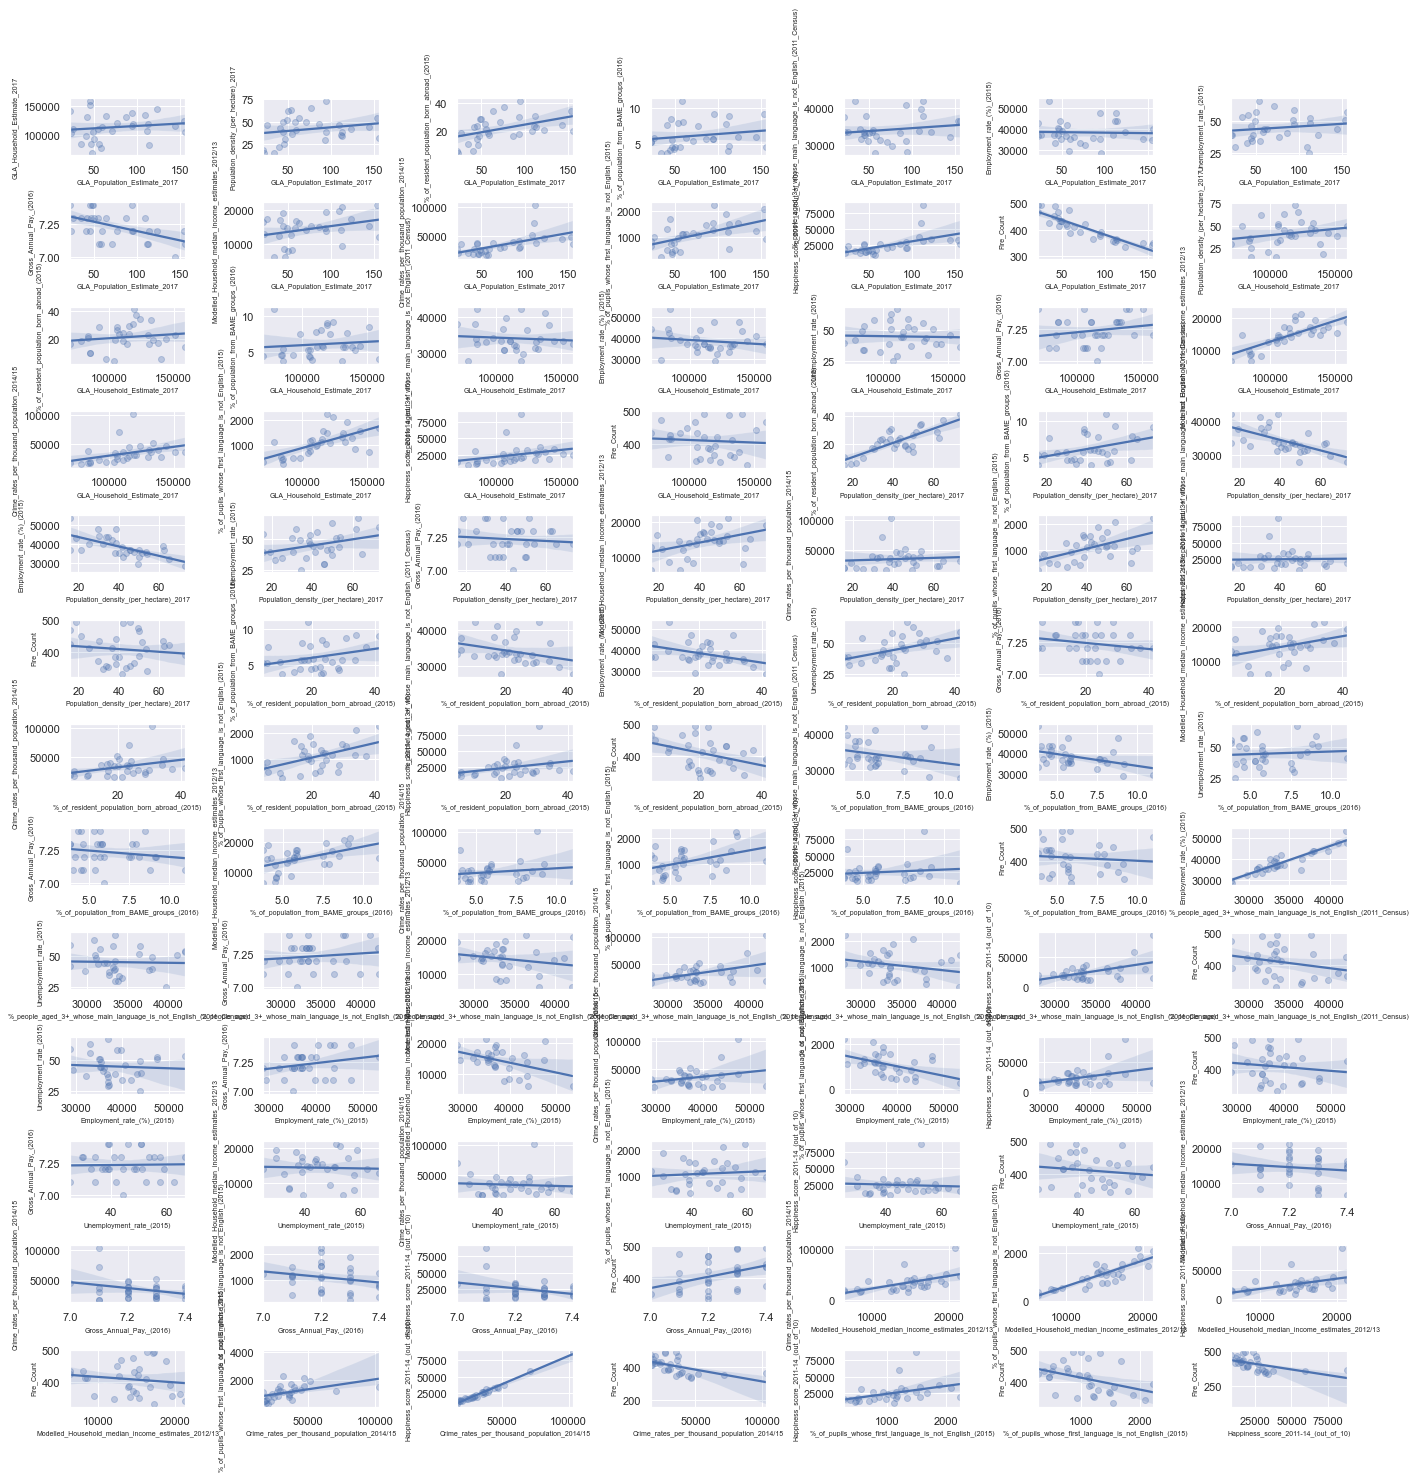

In [193]:
#Scatterplots of all fire counts and focus social data

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(19, 19))

df_corr = df_corr.astype(float)
focus2 = ['Population_density_(per_hectare)_2017'
      ,'GLA_Household_Estimate_2017'
      ,'%_of_population_from_BAME_groups_(2016)'
      ,'%_people_aged_3+_whose_main_language_is_not_English_(2011_Census)'
      ,'Unemployment_rate_(2015)'
      ,'Gross_Annual_Pay,_(2016)'
      ,'Modelled_Household_median_income_estimates_2012/13'
      ,'%_of_pupils_whose_first_language_is_not_English_(2015)'
      ,'Happiness_score_2011-14_(out_of_10)'
      ,'Fire_Count' 
      ,'Falsealarm_Count'
      ,'Malicious_Count'
      ,'AFA_Count'
      ,'MeanResponseTime']
df_corr = df_corr[focus2]
#fig, axes = plt.subplot(13,7)

count=1
for i in range(0,len(focus2)) :
    for j in range(i+1, len(focus2)) : 
        plt.subplot(13,7,count)
        b = sns.regplot(x=focus2[i], y=focus2[j], data=df_corr, scatter_kws = {'alpha': 0.3} )
        b.set_xlabel(focus[i],fontsize=7)
        b.set_ylabel(focus[j],fontsize=7)
        count+=1
plt.tight_layout()
plt.show()

In [184]:
#corr = df_corr[df_corr.columns[:]].corr()['MeanResponseTime'][:]
corr = c[c.columns[:]].corr()['MeanResponseTime'][:]

# corr.style.background_gradient(cmap='coolwarm')
print("Correlation on attendance time:")
corr

Correlation on attendance time:


GLA_Population_Estimate_2017                                         0.109324
GLA_Household_Estimate_2017                                         -0.074412
Population_density_(per_hectare)_2017                               -0.890003
%_of_resident_population_born_abroad_(2015)                         -0.375919
%_of_population_from_BAME_groups_(2016)                             -0.125822
%_people_aged_3+_whose_main_language_is_not_English_(2011_Census)   -0.371669
Employment_rate_(%)_(2015)                                           0.050325
Unemployment_rate_(2015)                                            -0.092103
Gross_Annual_Pay,_(2016)                                            -0.248408
Modelled_Household_median_income_estimates_2012/13                  -0.131481
Crime_rates_per_thousand_population_2014/15                         -0.561447
%_of_pupils_whose_first_language_is_not_English_(2015)              -0.136762
Happiness_score_2011-14_(out_of_10)                             

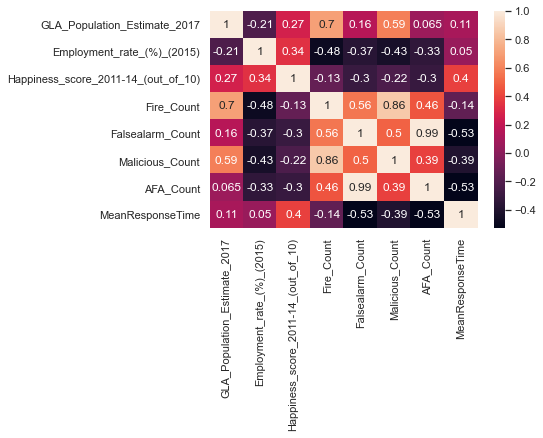

In [189]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

focus = ['GLA_Population_Estimate_2017'
      ,'GLA_Household_Estimate_2017'
      ,'Population_density_(per_hectare)_2017'
      ,'%_of_resident_population_born_abroad_(2015)'
      ,'%_of_population_from_BAME_groups_(2016)'
      ,'%_people_aged_3+_whose_main_language_is_not_English_(2011_Census)'
      ,'Employment_rate_(%)_(2015)'
      ,'Unemployment_rate_(2015)'
      ,'Gross_Annual_Pay,_(2016)'
      ,'Modelled_Household_median_income_estimates_2012/13'
      ,'Crime_rates_per_thousand_population_2014/15'
      ,'%_of_pupils_whose_first_language_is_not_English_(2015)'
      ,'Happiness_score_2011-14_(out_of_10)'
      ,'Fire_Count' 
      ,'Falsealarm_Count'
      ,'Malicious_Count'
      ,'AFA_Count'
      ,'MeanResponseTime']

df_corr = social_combine.copy()
df_corr = df_corr[focus]

corrMatrix = df_corr.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## 1. Motivation

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

The primary datasets in use are [The London Fire Brigade incident data from 2009-2021](https://data.london.gov.uk/dataset/london-fire-brigade-incident-records) and the [The London Fire Brigade mobilisation records from 2009-2021](https://data.london.gov.uk/dataset/london-fire-brigade-mobilisation-records) combined using IncidentNumber.

These datasets were chosen due to their high amount of both records and attributes. Given that the *London Fire Brigade* is the biggest and bussiest fire and rescure service in the country, it was also the obvious choice in search of information regarding fire incdidents.

Multiple additional datasets are used in combination with the datasets acquired from the *London Fire Brigade*. This involves ...

Given the initial information provided in the decribed datasets, we were hoping to ...

## 2. Basic stats

* Write about your choices in data cleaning and preprocessing

* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

### Data preperation

All incident data from the *London Fire Brigade* from 2009 to 2021 is first retrieved and concatenated:

In [2]:
# Recieve all years
lfb_i1 = pd.read_excel('LFB Incident data from January 2009 to December 2012.xlsx')
lfb_i2 = pd.read_excel('LFB Incident data from January 2013 to December 2016.xlsx')
lfb_i3 = pd.read_excel('LFB Incident data from January 2017.xlsx')

# Concatenate all years
lfb_i_frames = [lfb_i1, lfb_i2, lfb_i3]
lfbi_data = pd.concat(lfb_i_frames)

Geographical locations of incidents are considered of big importance. However, unlike the other accompanied datasets, the entries in the LFB datasets contains **Easting_rounded** and **Northing_rounded** values instead of longitude and latitude. Hence, supporting columns of longitudes and latitudes are added using the library *PyBNG*:

In [ ]:
# init empty columns
lfbi_data['Latitude'] = np.nan
lfbi_data['Longitude'] = np.nan

# Calculate lon and lat
for idx, row in lfbi_data.iterrows():
    
    try:
        lat = PyBNG(easting = row['Easting_rounded'], northing = row['Northing_rounded']).get_latlon()[0]
        lfbi_data.at[idx, 'Latitude'] = lat
    except:
        lfbi_data.at[idx, 'Latitude'] = np.nan
        
    try:
        lon = PyBNG(easting = row['Easting_rounded'], northing = row['Northing_rounded']).get_latlon()[1]
        lfbi_data.at[idx, 'Longitude'] = lon
    except:
        lfbi_data.at[idx, 'Longitude'] = np.nan

With help from the library *missingno*, we can visually get a good grasp of the amount of missing datapoints (nAn/null values) for each attrivute in the dataset.

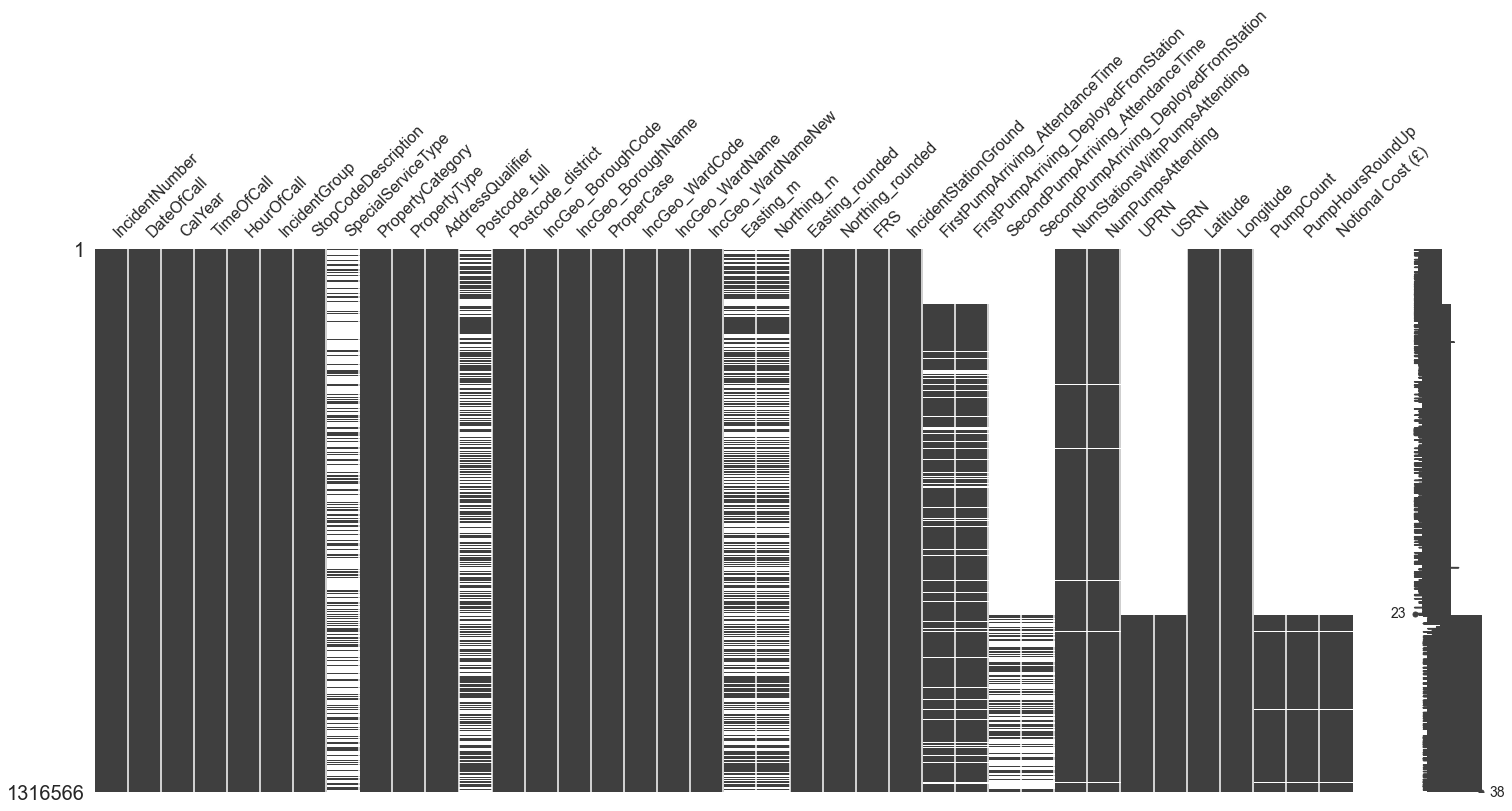

In [5]:
msno.matrix(lfbi_data)
plt.show()

It is clear that important attributes containing incident numbers, date and time, property information and geograpical positions generally does not suffer from lacking information.

On the other hand however, attribues such as *SpecialServiceType*, *National Cost* and pump related features cannot be considered guaranteed information.

It happens that there are only 31 columns in the datasets from 2009-2012 and 2013-2016, whereas there are 38 in the 2017+ dataset - i.e. there are 7 new columns in the newest dataset. These 'newly' supplied attributes are: 

* `UPRN`
* `USRN`
* `Latitude`
* `Longitude`
* `PumpCount`
* `PumpHoursRoundUp`
* `National Cost (£)`

As of now, all the columns are present in the merged dataframe with `NaN` values for the older years.

As it is expected that the day of the week and month of the year influence the amount and handeling of fires in London, columns with according information are also appended to the dataframe based on *DateOfCall*.

In [1]:
lfbi_data['Month'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).month - 1
lfbi_data['MonthName'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).month_name()
lfbi_data['Weekday'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).weekday
lfbi_data['WeekdayName'] = pd.DatetimeIndex(lfbi_data['DateOfCall']).day_name()

NameError: name 'pd' is not defined

The incident and mobilisation datasets from the Londong Fire Brigade share the same *IncidentNumber* value. As the mobilisation sets contains critical performance information on each incident, these datasets are acquired and merged with the prepared incident dataset.

In [8]:
# Read all datafiles
lfb_m1 = pd.read_excel('LFB Mobilisation data from Jan2009-Dec2012.xlsx')
lfb_m2 = pd.read_excel('LFB Mobilisation data from Jan 2013.xlsx')
lfb_m3 = pd.read_excel('LFB Mobilisation data from January 2017.xlsx')

# Concatenate all years
lfb_m_frames = [lfb_m1, lfb_m2, lfb_m3]
lfbm_data = pd.concat(lfb_m_frames)

In [9]:
lfb_data = pd.merge(lfbi_data, lfbm_data, how="inner", on="IncidentNumber")

In [13]:
print('Total LFB dataset size: {}'.format(lfb_data.shape))

Total LFB dataset size: (2038868, 77)


Given its big size with over 2 million entries and 77 features, the dataset takes a long time to load. The dataframe will hence be saved using *Pickle* and loaded from this instance as **firedata**.

In [2]:
#pd.to_pickle(lfb_data, "./firedata.pkl")
firedata = pd.read_pickle("./firedata.pkl")

The combined set of data can now be inspected:

In [3]:
pd.set_option('display.max_columns', None)
firedata.head()

IncidentNumber DateOfCall  CalYear TimeOfCall  HourOfCall    IncidentGroup  \
0      235138081 2009-01-01     2009   00:00:37           0  Special Service   
1      235138081 2009-01-01     2009   00:00:37           0  Special Service   
2           2091 2009-01-01     2009   00:03:00           0             Fire   
3           3091 2009-01-01     2009   00:04:27           0             Fire   
4           5091 2009-01-01     2009   00:05:39           0             Fire   

  StopCodeDescription SpecialServiceType PropertyCategory  \
0     Special Service                RTC     Road Vehicle   
1     Special Service                RTC     Road Vehicle   
2      Secondary Fire                NaN          Outdoor   
3      Secondary Fire                NaN          Outdoor   
4      Secondary Fire                NaN          Outdoor   

                                  PropertyType  \
0                                         Car    
1                                         Car    
2                       Road surface/pavement    
3  Domestic garden (vegetation not equipment)    
4        Cycle path/public footpath/bridleway    

                        AddressQualifier Postcode_full Postcode_district  \
0  In street close to gazetteer location      SW11 4LB              SW11   
1  In street close to gazetteer location      SW11 4LB              SW11   
2   In street outside gazetteer location        N9 9EL                N9   
3       On land associated with building      UB10 0DG              UB10   
4   In street outside gazetteer location        N7 8HG                N7   

  IncGeo_BoroughCode IncGeo_BoroughName  ProperCase IncGeo_WardCode  \
0          E09000032         WANDSWORTH  Wandsworth       E05000620   
1          E09000032         WANDSWORTH  Wandsworth       E05000620   
2          E09000010            ENFIELD     Enfield       E05000201   
3          E09000017         HILLINGDON  Hillingdon       E05000332   
4          E09000019          ISLINGTON   Islington       E05000375   

   IncGeo_WardName IncGeo_WardNameNew  Easting_m  Northing_m  Easting_rounded  \
0       Queenstown         Queenstown   528652.0    176830.0           528650   
1       Queenstown         Queenstown   528652.0    176830.0           528650   
2        Haselbury          Haselbury   533773.0    194492.0           533750   
3  Hillingdon East    Hillingdon East   507738.0    182805.0           507750   
4         Holloway           Holloway   531058.0    185307.0           531050   

   Northing_rounded     FRS IncidentStationGround  \
0            176850  London             Battersea   
1            176850  London             Battersea   
2            194450  London              Edmonton   
3            182850  London            Hillingdon   
4            185350  London              Holloway   

   FirstPumpArriving_AttendanceTime FirstPumpArriving_DeployedFromStation  \
0                               NaN                                   NaN   
1                               NaN                                   NaN   
2                               NaN                                   NaN   
3                               NaN                                   NaN   
4                               NaN                                   NaN   

   SecondPumpArriving_AttendanceTime SecondPumpArriving_DeployedFromStation  \
0                                NaN                                    NaN   
1                                NaN                                    NaN   
2                                NaN                                    NaN   
3                                NaN                                    NaN   
4                                NaN                                    NaN   

   NumStationsWithPumpsAttending  NumPumpsAttending  UPRN  USRN   Latitude  \
0                            2.0                2.0   NaN   NaN  51.634235   
1                            2.0                2.0   NaN   NaN  51.6

### Statistics

Provided our newly prepared indicent and mobilisation dataset, we can investigate which type of incidents occur most often:

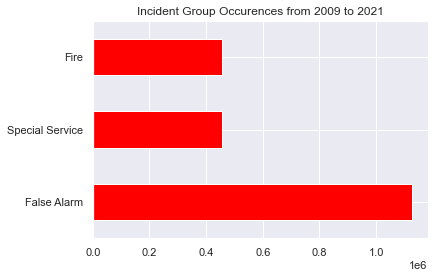

In [23]:
ig = firedata["IncidentGroup"].value_counts()
ig.plot.barh(title = 'Incident Group Occurences from 2009 to 2021', color = 'red');

Quite interestingly, false alarms occur more often than both fires ans special services combined.

Someone smart once said *rather be safe than sorry*, however given LFB is government funded, this will without doubt be a big cost for the system. We can with data collected from 2017 and unwards estimate the actual cost of false alarms:

In [39]:
fa = firedata[(firedata["IncidentGroup"] == 'False Alarm') & (firedata["CalYear"] >= 2017)]
print('Amount of false alarms reported 2017 and unwards: {}'.format(len(fa)))
fa_cost = fa['Notional Cost (£)'].sum()
print('Total national cost: {} £'.format(fa_cost))

Amount of false alarms reported 2017 and unwards: 376103
Total national cost: 149374843.0£


In total, the govenment has spend just below 150 million on false alarms since 2017!

Another fun and descriptive visualization is occurances of stop code occurences:

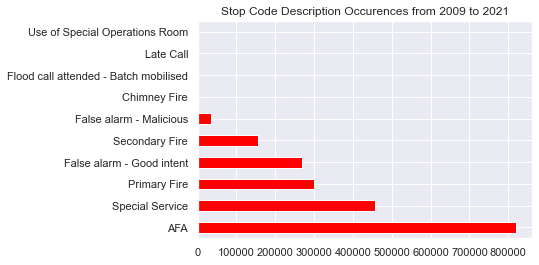

In [24]:
scd = firedata["StopCodeDescription"].value_counts()
scd.plot.barh(title = 'Stop Code Description Occurences from 2009 to 2021', color = 'red');

The AFA (Automatic Fire Alarm) system is responsible for the vast majority of reported incidents. We can investigate the amount of AFA's calls that's responsible of false alarms too:

In [45]:
fa_afa = firedata[(firedata["IncidentGroup"] == 'False Alarm') & (firedata["CalYear"] >= 2017) & (firedata["StopCodeDescription"] == 'AFA')]
print('Amount of false alarms caused by AFA reported 2017 and unwards: {}'.format(len(fa_afa)))
print('Shares of false alarms causes by AFA out of all: {:.2f}%'.format(len(fa_afa)/len(fa)*100))
fa__afa_cost = fa_afa['Notional Cost (£)'].sum()
print('Total national cost: {} £'.format(fa__afa_cost))
print('Shares of national cost (AFA): {:.2f}%'.format(fa__afa_cost/fa_cost*100))

Amount of false alarms caused by AFA reported 2017 and unwards: 284138
Shares of false alarms causes by AFA out of all: 75.55%
Total national cost: 109467889.0 £
Shares of national cost (AFA): 73.28%


It is clear that the AFA system is rensponsible for too many false alarms, with costs reaching almost 110 million pounds in just over 3 years of time. This actually happens to be a problem not just in England, but all around the world. The australian fire and rescure service for instance have comitted themselves to take necesarry measures to bring their amount of false AFA calls down: https://www.fire.nsw.gov.au/page.php?id=77

We can also investigate which type of special services are used most often:

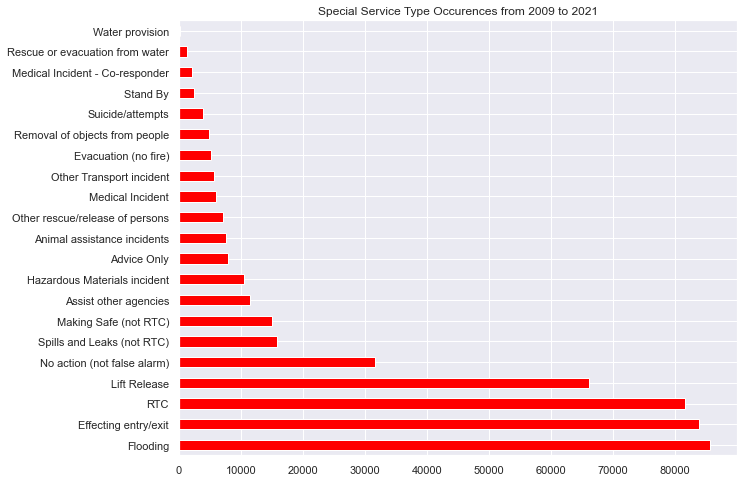

In [25]:
sst = firedata["SpecialServiceType"].value_counts()
sst.plot.barh(figsize = (10,8), title = 'Special Service Type Occurences from 2009 to 2021', color = 'red');

Incidents are reported on numourus different property categories:

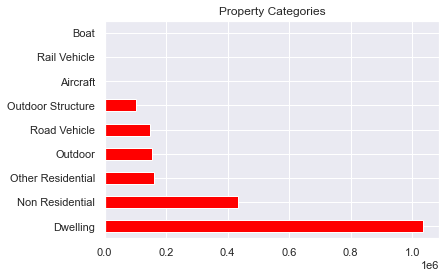

In [26]:
pc = firedata["PropertyCategory"].value_counts()
pc.plot.barh(title = 'Property Categories', color = 'red');

This only covers major categories however. There turns out to be a much larger amount of property types:

In [28]:
pt = firedata["PropertyType"].unique()
print('Amount of unique property types: {}'.format(len(pt)))

Amount of unique property types: 293


The dataset also holds information regarding address specific information which might be usefull in later analysis using machine learning, given that this most likely inflect response and handling time.

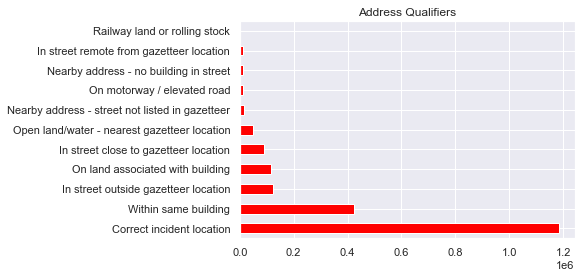

In [29]:
aq = firedata["AddressQualifier"].value_counts()
aq.plot.barh(title = 'Address Qualifiers', color = 'red');

## 3. Data Analysis

* Describe your data analysis and explain what you've learned about the dataset.
* If relevant, talk about your machine-learning.

### Critical areas

To get a better understanding of the incidents acted upon, and for potential firefighters to be better prepared for future reported incidents, it is extremely important to know which areas requires most focus.

For this reason, we investigate which areas in London have the highest amount of reported incidents using Folium:

In [10]:
london_lat = 51.5074
london_lon = 0.1278
zoom = 10

ldnheat = folium.Map(location=[london_lat, london_lon],
                     tiles = "Stamen Terrain",
                     zoom_start = zoom) 

# Ensure you're handing it floats
lfb_data['Latitude'] = lfb_data['Latitude'].astype(float)
lfb_data['Longitude'] = lfb_data['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
#heat_df = df_acc[df_acc['Speed_limit']=='40'] # Reducing data size so it runs faster
heat_df = lfb_data[(lfb_data['CalYear']==2020) & (lfb_data['Month']==5) & (lfb_data['Weekday']==5) & (lfb_data['IncidentGroup']=='Fire')] # Reducing data size so it runs faster
heat_df = heat_df[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(ldnheat)

# Display the map
ldnheat

## 4. Genre 
* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

## 5. Visualizations
* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

## 6. Discussion
* What went well?,
* What is still missing? What could be improved?, Why?

## 7. Contributions
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".